In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import statsmodels.api as sm

In [118]:
df = pd.read_csv('health.csv')
df.columns = ['date','click']
df

,date,click
0,2019-01-01,36
1,2019-01-02,45
2,2019-01-03,41
3,2019-01-04,40
4,2019-01-05,40
...,...,...
360,2019-12-27,86
361,2019-12-28,80
362,2019-12-29,87
363,2019-12-30,88


#### 시계열 데이터의 조건
- 1년 이상 수집 (계절성을 반영하기 위함)
- 연속성 (일정한 간격으로 빠짐없이 데이터가 수집 되어야함)
- 선형성 전제 4가지를 만족해야함 (선형성, 독립성, 등분산성, 정규성)

In [119]:
df['click'].isnull().sum()

0

In [120]:
#데이터 타입 확인
type(df['date'][0])
#datetime 변환
df['date'] = pd.to_datetime(df['date'])
type(df['date'][0])


pandas._libs.tslibs.timestamps.Timestamp

<AxesSubplot: xlabel='date'>

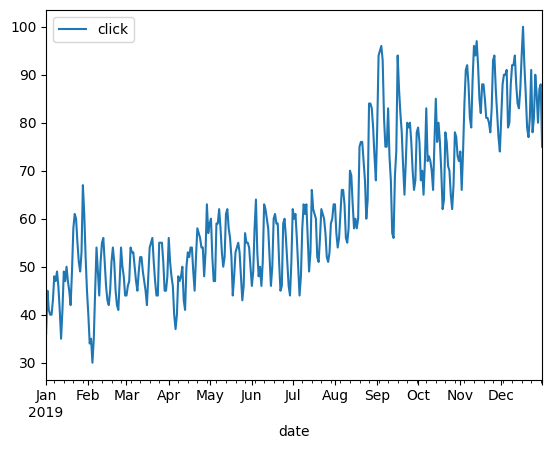

In [121]:
df.plot(x='date', y='click')

### 일반회귀분석

In [122]:
x = range(len(df['date']))
y = df['click']

x = sm.add_constant(x)
model = sm.OLS(y,x) #종속변수(y) 먼저 넣고 뒤에 독립변수(x)
result = model.fit()
print(result.params)

const    39.057534
x1        0.126554
dtype: float64


In [123]:
# y절편
a = result.params[0]

# 기울기
b = result.params[1]

In [124]:
df['prediction'] = [b * x + a for x in range(len(df['date']))]

In [125]:
df1 = df.copy()
df1['date'] = range(len(df1))
df1['pred'] = df1['date'].apply(lambda x: b*x+a)
df1

,date,click,prediction,pred
0,0,36,39.057534,39.057534
1,1,45,39.184089,39.184089
2,2,41,39.310643,39.310643
3,3,40,39.437197,39.437197
4,4,40,39.563751,39.563751
...,...,...,...,...
360,360,86,84.617071,84.617071
361,361,80,84.743625,84.743625
362,362,87,84.870179,84.870179
363,363,88,84.996733,84.996733


In [126]:
# # y = Bx + a
# prediction = []
# for x in range(len(df['date'])):
#     prediction.append(b * x + a)
# df['prediction'] = prediction
# df

<AxesSubplot: xlabel='date'>

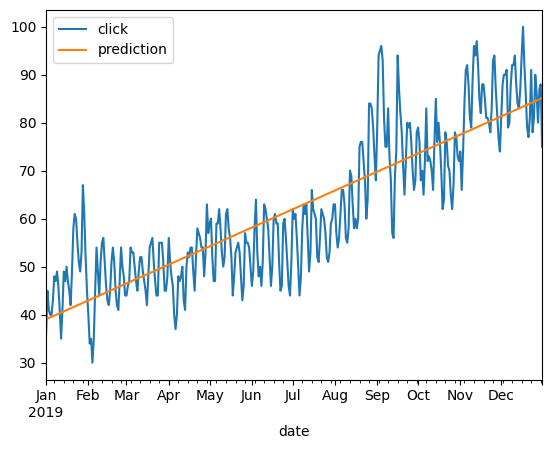

In [127]:
df.plot(x='date', y = ['click','prediction'])

In [128]:
mse =[]
for a, i in enumerate(df['click']):
    mse.append((i-df['prediction'][a])**2)
np.mean(mse)

64.7166329373385

In [129]:
# 0 = 일요일, 1= 월요일
yoil = [2,3,4,5,6,0,1]
season = []
for i in range(len(df['click'])//len(yoil)):
    for w in yoil:
        season.append(w)
season.append(2)
len(season)

365

In [130]:
df['season'] = season
df

,date,click,prediction,season
0,2019-01-01,36,39.057534,2
1,2019-01-02,45,39.184089,3
2,2019-01-03,41,39.310643,4
3,2019-01-04,40,39.437197,5
4,2019-01-05,40,39.563751,6
...,...,...,...,...
360,2019-12-27,86,84.617071,5
361,2019-12-28,80,84.743625,6
362,2019-12-29,87,84.870179,0
363,2019-12-30,88,84.996733,1


In [131]:
df['trend'] = df.index
df

,date,click,prediction,season,trend
0,2019-01-01,36,39.057534,2,0
1,2019-01-02,45,39.184089,3,1
2,2019-01-03,41,39.310643,4,2
3,2019-01-04,40,39.437197,5,3
4,2019-01-05,40,39.563751,6,4
...,...,...,...,...,...
360,2019-12-27,86,84.617071,5,360
361,2019-12-28,80,84.743625,6,361
362,2019-12-29,87,84.870179,0,362
363,2019-12-30,88,84.996733,1,363


In [132]:
x = df[['season','trend']]
y = df['click']

x = sm.add_constant(x)
model = sm.OLS(y,x) #종속변수(y) 먼저 넣고 뒤에 독립변수(x)
result = model.fit()
print(result.params)

const     42.960569
season    -1.291633
trend      0.126380
dtype: float64


<AxesSubplot: xlabel='date'>

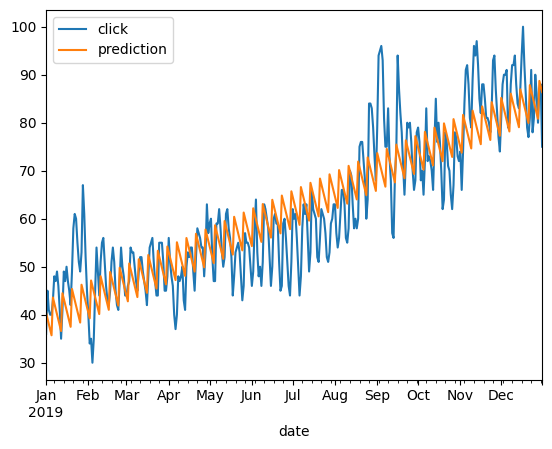

In [133]:
# y절편
a = result.params[0]

# season 계수
b1 = result.params[1]

# trend 계수
b2 = result.params[2]

prediction = []
for i in range(len(df['date'])):
    prediction.append(b1 * df['season'][i] + b2 * df['trend'][i] + a )
df['prediction'] = prediction

df.plot(x = 'date', y = ['click','prediction'])

In [134]:
mse =[]
for a, i in enumerate(df['click']):
    mse.append((i-df['prediction'][a])**2)
np.mean(mse)

58.05742898051807

### interrupted time series Analysis

In [135]:
#LG와 삼성 언급량 데이터
df = pd.read_csv('LGSS.csv')
df.columns = ['date', 'lg', 'samsung']

<AxesSubplot: xlabel='date'>

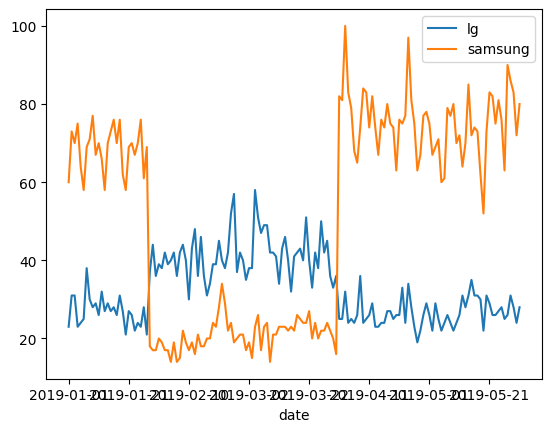

In [136]:
df.plot(x= 'date', y = ['lg','samsung'])

In [137]:
#삼성 회기분석
x = range(len(df['date']))
y = df['samsung']

x = sm.add_constant(x)
model = sm.OLS(y,x) #종속변수(y) 먼저 넣고 뒤에 독립변수(x)
result = model.fit()
print(result.params)

const    32.974904
x1        0.243778
dtype: float64


In [138]:
# y절편
a = result.params[0]

# 기울기
b = result.params[1]

prediction = []
for x in range(len(df['date'])):
    prediction.append(b * x + a )
df['prediction'] = prediction

In [139]:
df

,date,lg,samsung,prediction
0,2019-01-01,23,60,32.974904
1,2019-01-02,31,73,33.218682
2,2019-01-03,31,70,33.462461
3,2019-01-04,23,75,33.706239
4,2019-01-05,24,64,33.950017
...,...,...,...,...
146,2019-05-27,26,90,68.566539
147,2019-05-28,31,86,68.810317
148,2019-05-29,28,83,69.054096
149,2019-05-30,24,72,69.297874


<AxesSubplot: xlabel='date'>

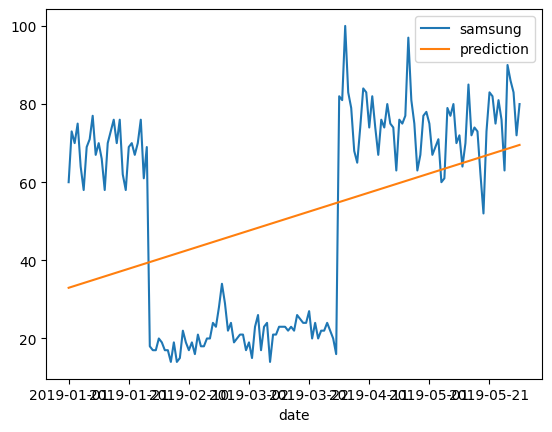

In [140]:
df.plot(x='date', y = ['samsung', 'prediction'])

In [141]:
before = df.iloc[:27] #변화가 시작되는 번호 
after = df.iloc[90:] #변화가 끝나는 번호
left = df.iloc[27:90] # 변화가 있는 날짜 1월 28일부터 3월 31일까지 무슨 일이 있었다.

In [142]:
right = pd.concat([before, after], axis=0)
right

,date,lg,samsung,prediction
0,2019-01-01,23,60,32.974904
1,2019-01-02,31,73,33.218682
2,2019-01-03,31,70,33.462461
3,2019-01-04,23,75,33.706239
4,2019-01-05,24,64,33.950017
...,...,...,...,...
146,2019-05-27,26,90,68.566539
147,2019-05-28,31,86,68.810317
148,2019-05-29,28,83,69.054096
149,2019-05-30,24,72,69.297874


In [143]:
x = right.index
y = right['samsung']

x = sm.add_constant(x)
model = sm.OLS(y,x) #종속변수(y) 먼저 넣고 뒤에 독립변수(x)
result = model.fit()
print(result.params)

const    68.427246
x1        0.052718
dtype: float64


<AxesSubplot: xlabel='date'>

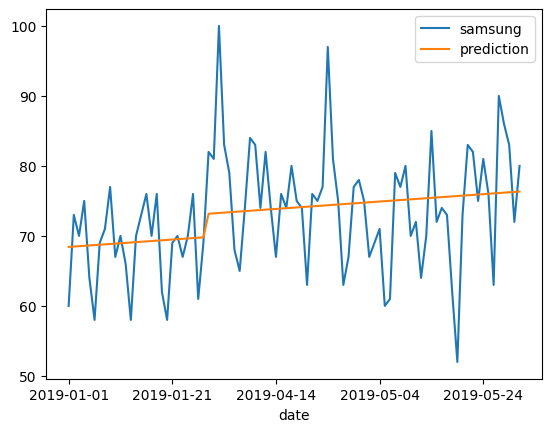

In [144]:
# y절편
a = result.params[0]

# 기울기
b = result.params[1]

prediction = []
for x in right.index:
    prediction.append(b * x + a )
right['prediction'] = prediction
right.plot(x='date', y = ['samsung', 'prediction'])

In [145]:
x = left.index
y = left['samsung']

x = sm.add_constant(x)
model = sm.OLS(y,x) #종속변수(y) 먼저 넣고 뒤에 독립변수(x)
result = model.fit()
print(result.params)

const    16.149098
x1        0.081173
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_10520\2893608832.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left['prediction'] = prediction


<AxesSubplot: xlabel='date'>

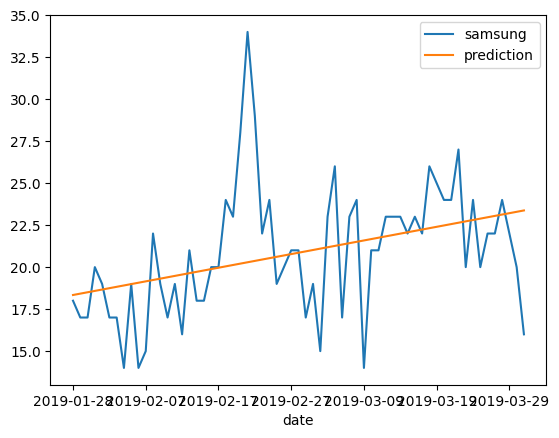

In [146]:
# y절편
a = result.params[0]

# 기울기
b = result.params[1]

prediction = []
for x in left.index:
    prediction.append(b * x + a )
left['prediction'] = prediction
left.plot(x='date', y = ['samsung', 'prediction'])

In [147]:
df2 = pd.concat([right.iloc[:27], left, right.iloc[27:]], axis=0)
df2

,date,lg,samsung,prediction
0,2019-01-01,23,60,68.427246
1,2019-01-02,31,73,68.479964
2,2019-01-03,31,70,68.532683
3,2019-01-04,23,75,68.585401
4,2019-01-05,24,64,68.638119
...,...,...,...,...
146,2019-05-27,26,90,76.124123
147,2019-05-28,31,86,76.176841
148,2019-05-29,28,83,76.229560
149,2019-05-30,24,72,76.282278


<AxesSubplot: xlabel='date'>

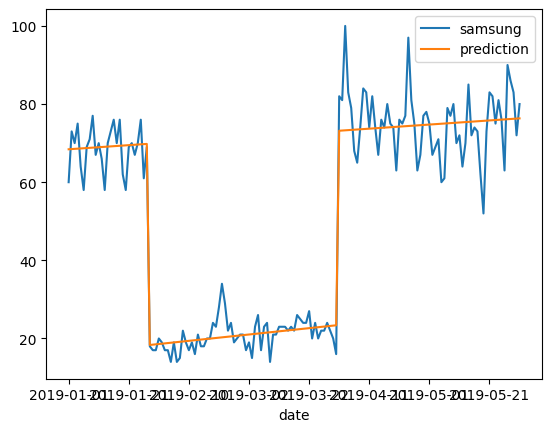

In [148]:
df2.plot(x='date', y = ['samsung', 'prediction'])

### interrupted time series Analysis

In [149]:
#LG와 삼성 언급량 데이터
df = pd.read_csv('LGSS.csv')
df.columns = ['date', 'lg', 'samsung']
df

,date,lg,samsung
0,2019-01-01,23,60
1,2019-01-02,31,73
2,2019-01-03,31,70
3,2019-01-04,23,75
4,2019-01-05,24,64
...,...,...,...
146,2019-05-27,26,90
147,2019-05-28,31,86
148,2019-05-29,28,83
149,2019-05-30,24,72


In [150]:
moderator = []

for i in range(27):
    moderator.append(0)
for i in range(90-27):
    moderator.append(1)
for i in range(151-90):
    moderator.append(0)
len(moderator)

151

In [151]:
df['interruption'] = moderator
df

,date,lg,samsung,interruption
0,2019-01-01,23,60,0
1,2019-01-02,31,73,0
2,2019-01-03,31,70,0
3,2019-01-04,23,75,0
4,2019-01-05,24,64,0
...,...,...,...,...
146,2019-05-27,26,90,0
147,2019-05-28,31,86,0
148,2019-05-29,28,83,0
149,2019-05-30,24,72,0


In [152]:
df['trend'] = df.index

In [153]:
df['interaction'] = df['trend'] * df['interruption']
df

,date,lg,samsung,interruption,trend,interaction
0,2019-01-01,23,60,0,0,0
1,2019-01-02,31,73,0,1,0
2,2019-01-03,31,70,0,2,0
3,2019-01-04,23,75,0,3,0
4,2019-01-05,24,64,0,4,0
...,...,...,...,...,...,...
146,2019-05-27,26,90,0,146,0
147,2019-05-28,31,86,0,147,0
148,2019-05-29,28,83,0,148,0
149,2019-05-30,24,72,0,149,0


In [154]:
x = df[["trend", "interruption","interaction"]] # B1 , B2, B3순 (y = B1x + B2m + B3mx + a)
y = df["samsung"]

x = sm.add_constant(x)
model = sm.OLS(y, x)
result = model.fit()
print(result.params)

const           68.427246
trend            0.052718
interruption   -52.278149
interaction      0.028455
dtype: float64


In [155]:
# y절편
a = result.params[0]

# 기울기
b1 = result.params[1]

# 조절항
b2 = result.params[2]

# 상호작용항
b3 = result.params[3]

prediction = []
for i in df.index:
    prediction.append(b1 * df["trend"][i] + b2 * df["interruption"][i]+ b3 * df["interaction"][i] + a)
df["prediction"] = prediction
df

,date,lg,samsung,interruption,trend,interaction,prediction
0,2019-01-01,23,60,0,0,0,68.427246
1,2019-01-02,31,73,0,1,0,68.479964
2,2019-01-03,31,70,0,2,0,68.532683
3,2019-01-04,23,75,0,3,0,68.585401
4,2019-01-05,24,64,0,4,0,68.638119
...,...,...,...,...,...,...,...
146,2019-05-27,26,90,0,146,0,76.124123
147,2019-05-28,31,86,0,147,0,76.176841
148,2019-05-29,28,83,0,148,0,76.229560
149,2019-05-30,24,72,0,149,0,76.282278


<AxesSubplot: xlabel='date'>

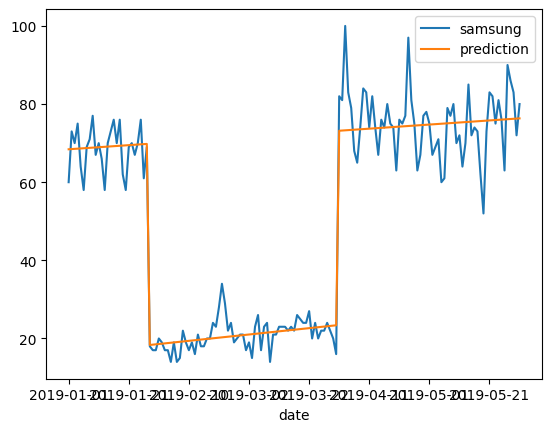

In [156]:
df.plot(x='date', y = ['samsung', 'prediction'])

In [161]:
df['date'] = pd.to_datetime(df['date'])

In [163]:
mse =[]
for a, i in enumerate(df['samsung']):
    mse.append((i-df['prediction'][a])**2)
np.mean(mse)
df['mse'] = mse

<AxesSubplot: xlabel='date'>

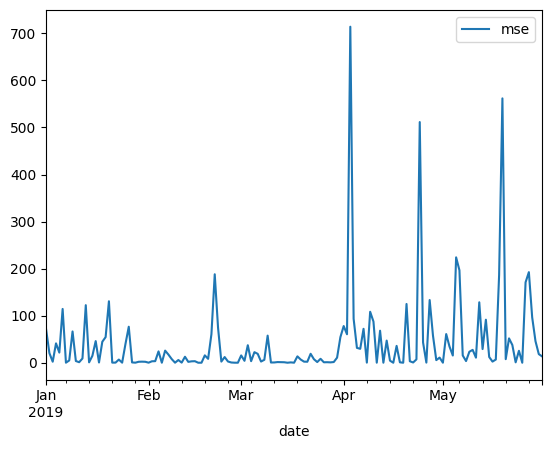

In [164]:
df.plot(x='date', y= 'mse')

<AxesSubplot: xlabel='date'>

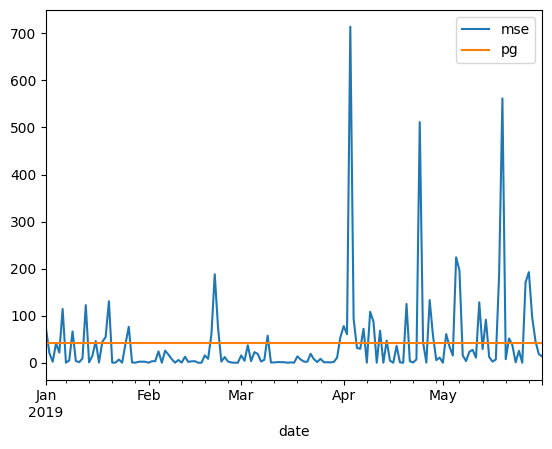

In [165]:
pg = np.mean(mse)
df['pg'] = pg
df.plot(x='date', y= ['mse','pg'])

<AxesSubplot: xlabel='date'>

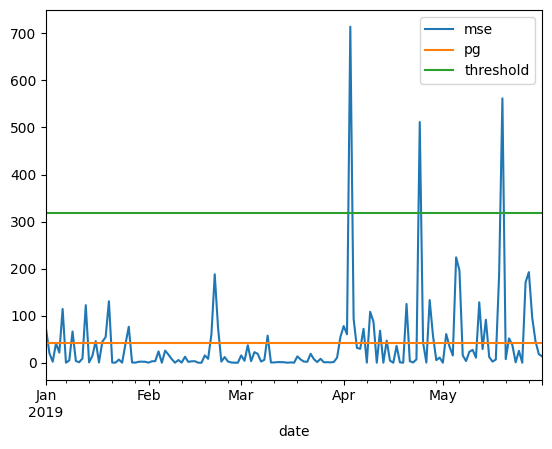

In [166]:
threshold = pg + np.std(mse) *3 
df['threshold'] = threshold
df.plot(x='date', y= ['mse','pg','threshold'])


In [167]:
#이상치 처리
for a, i in enumerate(mse):
    if i > threshold:
        print(a)

92
113
138


In [171]:
print(df.iloc[92]['date'])
print(df.iloc[113]['date'])
print(df.iloc[138]['date'])

2019-04-03 00:00:00
2019-04-24 00:00:00
2019-05-19 00:00:00


- 2019 4월3일 삼성 라이온즈 연패 끊었다.
- 2019 4/24 비메모리 바도체 133조 투자, 갤탭S5e 출시
- 2019 5/19 삼성 바이로직스 분식회계